# Instructions: {-}

a.	You may talk to a friend, discuss the questions and potential directions for solving them. However, you need to write your own solutions and code separately, and not as a group activity.

b.	Do not write your name on the assignment. (1 point)

c.	Export your Jupyter notebook as a PDF file. If you get an error, make sure you have downloaded the MikTex software (for windows) or MacTex (for mac). Note that after installing MikTex/MacTex, you will need to check for updates, install the updates if needed, and re-start your system. Submit the PDF file. (1 point)

d.	Please include each question (or question number) followed by code and your answer (if applicable). Write your code in the ‘Code’ cells and your answer in the ‘Markdown’ cells of the Jupyter notebook. Ensure that the solution is well-organized, clear, and concise (3 points)
1.	It’s easy enough to identify different sections of the homework assignment (e.g., if there are different sections of an assignment, they’re clearly distinguishable by section headers or the like)  
2.	It’s clear which code/markdown blocks correspond to which questions. 
3.	There aren’t excessively long outputs of extraneous information (e.g., no printouts of entire data frames without good reason) 

This assignment is **due at 11:59pm on Wednesday, April 27th**. Good luck!

Submissions will be graded with a maximum of 55 points – 50 points for code & answers, 5 points for anonymity and proper formatting. However, your final grade in the assignment will be scaled to be out of 100 points. For example, if you scored 27.5/55 in the assigment, your score will be scaled to 50/100

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc,make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# Part 1

# Q1a {-}
Develop a decision tree model on the data *house_feature_train.csv* to predict *house_price*. Use all the predictors except *house_id*. What is the: \
(i) model depth and, \
(ii) number of leaves in the model?

**Hint:** Use the attribute *tree_* to get the attributes of the tree model. Example: *model.tree.n_leaves* is the number of leaves of the tree *model*.

*(2 points for code, 1 point for answer)*

In [2]:
train = pd.merge(pd.read_csv('house_feature_train.csv'), pd.read_csv('house_price_train.csv'))
test = pd.merge(pd.read_csv('house_feature_test.csv'), pd.read_csv('house_price_test.csv'))

In [3]:
X = train.drop(columns = ['house_id', 'house_price'])
y = train['house_price']

In [4]:
model = DecisionTreeRegressor(random_state=1)
model.fit(X,y)

DecisionTreeRegressor(random_state=1)

In [5]:
model.get_depth()

16

In [6]:
model.get_n_leaves()

249

The model has a depth of 16 and 249 nodes.

# Q1b {-}
Find the RMSE of the model developed in the previous question on *house_feature_test.csv*.

*(1 point for code, 1 point for answer)*

In [7]:
X_test = test.drop(columns = ['house_id', 'house_price'])
np.sqrt(mean_squared_error(test['house_price'], model.predict(X_test)))

440.11904192007887

The RMSE of the model on the test data is approximately $440.12.

# Q1c {-}
For the model developed in *Q1a*, use 5-fold cross validation to optimize the *depth, number of leaves, minimum number of observations in a node required to split the node*, and *minimum number of observations required in a leaf*. Report the optimal values of these parameters.

Use the following arguments: \
(i) Use `random_state=1` when defining the `KFold` object, \
(ii) Since you are using `random_state=1` while defining the `KFold` object, you will need to use the `shuffle = True` argument, \
(iii) Use `random_state=1` with the `DecisionTreeRegressor` object.

**Note:** It is computationally expensive to consider a wide range of values of all the parameters. An optimization over any reasonable range (that your laptop can handle) is good enough. Different people may get different models, based on the range of values they consider to optimize the parameters.

**Hint:** The parameters of the `DecisionTreeRegressor` object to be optimized are `max_depth, max_leaf_nodes, min_samples_split and min_samples_leaf`.

*(4 points for code, 1 point for answer)*

In [7]:
parameters = {'max_depth': range(3, 11), 'max_leaf_nodes': range(12, 25),
              'min_samples_split': range(1,15), 'min_samples_leaf': range(7,25)}
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters, n_jobs=-1, verbose=1,
                    cv = cv)
model.fit(X, y)
print(model.best_score_, model.best_params_)

Fitting 5 folds for each of 26208 candidates, totalling 131040 fits
0.6766917122861764 {'max_depth': 6, 'max_leaf_nodes': 17, 'min_samples_leaf': 10, 'min_samples_split': 2}


# Q1d {-}
Update the decision tree model in *Q1a* based on the optimal values of parameters found in *Q1c*. Find the RMSE of the updated model on *house_feature_test.csv*.

*(2 points for code, 1 point for answer)*

In [8]:
X = train.drop(columns = ['house_id', 'house_price'])
model = DecisionTreeRegressor(max_depth=6, max_leaf_nodes=17, min_samples_leaf=10, min_samples_split=2, random_state=1)
model.fit(X,y)

DecisionTreeRegressor(max_depth=6, max_leaf_nodes=17, min_samples_leaf=10,
                      random_state=1)

In [9]:
X_test = test.drop(columns = ['house_id', 'house_price'])
np.sqrt(mean_squared_error(test['house_price'], model.predict(X_test)))

rmse: 447.1436934543615


# Q1e {-}
A decision tree model has varying levels of prediction accuracy over different segments of data. What are the charecterisitics of the houses for which the decision tree model, developed in *Q1d*, provides the most accurate estimate of *house_price*? Follow the steps below to answer this question.

For the model developed in *Q1d*: \
(i) Find the leaf that has the least *mean squared error (MSE)* \
(ii) Find the decision rules that classify an observation to the leaf identified in (i) \
(iii) Use the decision rules in (ii) to answer the question. For example, an answer can look like - "For houses with *house_age>3* and *number_convenience_stores<=2*, the model provides the most accurate estimate of *house_price*.

You may use the following functions to help you with the above steps. Given the functions, the problem is quite straightforward.

*(3 points for code, 1 point for answer)*

In [10]:
#The following function finds indices of the leaf nodes, given the decision tree model.
#The indices of nodes in a decision tree starts at the top from 0. 
#The child nodes obtained from the first split have indices 1 (left) and 2 (right), 
#the child nodes obtained from the second split have indices 3 (left) and 4 (right), and so on.
def leaf_nodes_indices(model):
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    leaf_nodes = []
    for i in range(model.tree_.node_count):
        if children_left[i] == children_right[i]:
            leaf_nodes.append(i)
    return leaf_nodes

#The following function finds the *mean squared error* of nodes with indices *node_indices*
def mse(model,node_indices):
    return model.tree_.impurity[node_indices]

#The following function gives the decision rules for a node with index as *node_index*
def decision_rules(model,node_index):
    child_node = node_index
    node_list=[]
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
    features=model.tree_.feature
    fnames = X.columns
    threshold = model.tree_.threshold
    p=1
    while p>0:
        if node_index%2>0:
            p= np.where(children_left==node_index)[0][0]
        else:
            p= np.where(children_right==node_index)[0][0]
        node_list.append(p)
        node_index=p
    node_list.reverse()
    node_list.append(child_node)
    cc=1
    for n in node_list[0:(len(node_list)-1)]:
        cnode = node_list[cc]
        if cnode%2==0:
            ineq_sign = ">"
        else:
            ineq_sign = "<="
        print("Split "+ str(cc)+":"+fnames[features][n]+ineq_sign+str(threshold[n]))
        cc=cc+1
    node_list=[]
    return ""

In [11]:
indices = leaf_nodes_indices(model)
mse(model, indices)

array([ 42613.488984  , 319056.51800273, 105493.11022644,  16445.10399017,
       377468.12055976, 520819.37867756, 107091.143544  , 796842.84915943,
       309528.96179501, 186607.65866925, 130426.66882469, 117062.75461775,
       504329.04707823, 227344.48497431, 788087.46770399,  49739.83199665,
        23782.49395976])

In [12]:
indices

[9, 11, 14, 15, 17, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32]

The leaf node that has the smallest MSE has an node index of 15.

In [13]:
decision_rules(model, 15)

Split 1:distance_MRT>390.7689971923828
Split 2:latitude<=24.964895248413086
Split 3:latitude<=24.950759887695312


''

For distance_MRT>390.7689971923828, latitude<=24.964895248413086, and latitude <= 24.950759887695312 the model provides the most accurate estimate of house_price.

# Q1f {-}
Predict the *house_price* of those houses in *house_feature_test.csv* that have the characteristics identified in *Q1e*. What is the RMSE?

*(2 points for code, 1 point for answer)*

In [14]:
# Used split 3 latitude as it has the lower latitude lower latitude 
X_test = test.drop(columns = ['house_id','house_price']).loc[(test['distance_MRT'] > 390.7689971923828) & 
                                                             (test['latitude'] <= 24.950759887695312)]
test_price = test.loc[(test['distance_MRT'] > 390.7689971923828) & 
                      (test['latitude'] <= 24.950759887695312)]

In [15]:
np.sqrt(mean_squared_error(test_price['house_price'],model.predict(X_test)))

181.00326025389404

# Q1g {-}
The decision tree model uses a greedy algorithm to fit the data. Thus it may choose an inferior split early on leading to an inferior model. Drop *longitude* from the set of predictors, and redo *Q1c* and *Q1d*. Report the RMSE of the model on *house_feature_test.csv*.

*(4 points for code, 1 point for answer)*

In [16]:
X = train.drop(columns = ['longitude', 'house_price', 'house_id'])

parameters = {'max_depth': range(3, 11), 'max_leaf_nodes': range(5, 17),
              'min_samples_split': range(1,11), 'min_samples_leaf': range(1,11)}
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = GridSearchCV(DecisionTreeRegressor(random_state = 1), parameters, n_jobs = -1, verbose = 1,
                    cv = cv)
model.fit(X, y)
print(model.best_score_, model.best_params_)

Fitting 5 folds for each of 2560 candidates, totalling 12800 fits
0.7094688362470212 {'max_depth': 6, 'max_leaf_nodes': 14, 'min_samples_leaf': 1, 'min_samples_split': 7}


In [17]:
X = train.drop(columns = ['longitude', 'house_price', 'house_id'])
model = DecisionTreeRegressor(max_depth=6, max_leaf_nodes=14, min_samples_leaf=1, min_samples_split=7)
model.fit(X,y)

X_test = test.drop(columns = ['house_id', 'house_price','longitude'])
np.sqrt(mean_squared_error(test['house_price'], model.predict(X_test)))

388.0778250436932

# Q1h {-}
Use minimal cost-complexity pruning to develop the decision tree for predicting house price. Use all the predictors except *house_id*. Also optimize *min_samples_split* while finding the optimal cost complexity parameter, *ccp_alpha*. Find the RMSE of the model developed with the optimal parameters on *house_feature_test.csv*.

**Note:** Different people may obtain different models.

*(3 points for code, 1 point for answer)*

In [18]:
# Parameterizing
X = train.drop(columns = ['house_id', 'house_price'])
y = train['house_price']

# Model + Alphas
model = DecisionTreeRegressor(random_state=1)
alphas = model.cost_complexity_pruning_path(X, y)['ccp_alphas']

# Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=1)
tree = GridSearchCV(model, param_grid={'ccp_alpha':alphas, 'min_samples_split': range(1,12)},
                    n_jobs=-1, verbose=1, cv=cv)
tree.fit(X, y)
print(tree.best_score_, tree.best_params_)

Fitting 5 folds for each of 2321 candidates, totalling 11605 fits
0.6354316097786957 {'ccp_alpha': 10358.958968117982, 'min_samples_split': 2}


In [19]:
X = train.drop(columns = ['house_id', 'house_price'])
X_test = test.drop(columns = ['house_id', 'house_price'])
model = DecisionTreeRegressor(random_state=1, ccp_alpha=10358.958968117982, min_samples_split=2)
model.fit(X,y)
np.sqrt(mean_squared_error(test['house_price'], model.predict(X_test)))

419.4366068685697

The RMSE for this model was 419.44. The optimal ccp_alpha found was 10358.958968117982 and the optimal min_sample_split was 2.

# Part 2 {-}
The data for this question is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls, where bank clients were called to subscribe for a term deposit. 

There is one train data - *train.csv*, which you will use to develop a model. There are two test datasets - *test1.csv* and *test2.csv*, which you will use to test your model. Each dataset has the following attributes about the clients called in the marketing campaign:

1) *age*: Age of the client\
2) *education*: Education level of the client \
3) *day*: Day of the month the call is made\
4) *month*: Month of the call \
5) *y*: did the client subscribe to a term deposit? \
6) *duration*: Call duration, in seconds. This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call *y* is obviously known. Thus, this input should only be included for inference purposes and should be discarded if the intention is to have a realistic predictive model.

(Raw data source: [Source](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Do not use the raw data source for this assingment. It is just for reference.)

**Note:** 
1. For optimizing models in this section you are free to choose any method you like - (i) cost complexity pruning (optimizing `ccp_alpha`) or (ii)  optimizing other decision tree parameters (parameters other than `ccp_alpha`), or (iii) a combination of (i) and (ii). \
2. Different people may get different models based on the parameters they consider for optimization. It is computationally infeasible to consider all possible parameter values.

In [13]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1]/(cm[1,1] + cm[0,1]))
    recall = 100*(cm[1,1]/(cm[1,1] + cm[1,0]))
    print("Accuracy = ", accuracy)
    print("FNR = ", fnr)
    print("Precision = ",precision)
    print("Recall = ",recall)
    print("Confusion matrix = \n", cm_df)
    return (" ")

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

# Q2a {-}
Develop a **decision tree model** (using *train.csv*) to predict the probability of a client subscribing to a term deposit based on *age, education, day* and *month*.The model must have both **precision and recall higher than 40%** on *train.csv*, *test1.csv* and *test2.csv*. Print the confusion matrices for all the three datasets - *train.csv*, *test1.csv* and *test2.csv*, along with their precision and recall.

**Hints:** \
(i) Make dummy variables for categorical predictors \
(ii) Optimize the depth and number of leaves of the decision tree, \
(ii) Make a precision-recall curve to find the threshold probability satisfying the criteria. \ 

*(6 points for code, 1 point for answer)*

In [10]:
train = pd.read_csv('train.csv')
test1 = pd.read_csv('test1.csv')
test2 = pd.read_csv('test2.csv')
y = pd.get_dummies(train['y'], drop_first=True)

In [11]:
X_train = pd.get_dummies(train.drop(columns=['duration', 'y']))
y_train = pd.get_dummies(train['y'], drop_first=True)['yes']
X_test1 = pd.get_dummies(test1.drop(columns=['duration', 'y', 'default']))
y_test1 = pd.get_dummies(test1['y'], drop_first=True)['yes']
X_test2 = pd.get_dummies(test2.drop(columns=['duration', 'y']))
y_test2 = pd.get_dummies(test2['y'], drop_first=True)['yes']

In [23]:
skf = StratifiedKFold(n_splits=5)
model = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid={'max_depth': range(1,30), 'max_leaf_nodes': range(3,50)},
                    n_jobs=-1, verbose=1, cv=skf, scoring=['precision','recall','accuracy'], refit = 'recall')
model.fit(X_train,y_train)
print(model.best_score_, model.best_params_)

Fitting 5 folds for each of 1363 candidates, totalling 6815 fits
0.15911143459790264 {'max_depth': 16, 'max_leaf_nodes': 44}


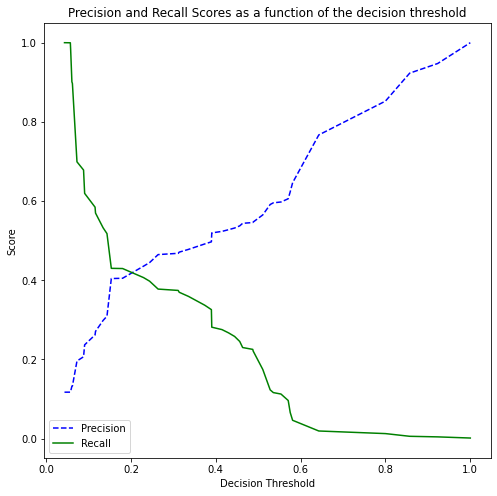

In [14]:
model = DecisionTreeClassifier(random_state=1, max_depth=16, max_leaf_nodes=44)
model.fit(X_train,y_train)

ypred = model.predict_proba(X_train)[:, 1]
p, r, thresholds = precision_recall_curve(y, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [25]:
print(p)

[0.1172739  0.11732243 0.11962589 0.13218001 0.13289768 0.19605029
 0.20671221 0.23688379 0.26192816 0.27088402 0.29853805 0.30918085
 0.40426019 0.40500804 0.4355428  0.44456551 0.46476762 0.46800731
 0.47097175 0.47795071 0.49164593 0.49702602 0.51956815 0.52339046
 0.52768416 0.53189352 0.53735326 0.5437788  0.54572271 0.54710145
 0.56501182 0.59133489 0.59550562 0.59767141 0.60582822 0.62355658
 0.6462585  0.76699029 0.85245902 0.92307692 0.94736842 1.
 1.        ]


In [15]:
thresholds[14]

0.22981366459627328

In [16]:
print(confusion_matrix_data(X_train, y_train, model, cutoff=0.22981366459627328))
print(confusion_matrix_data(X_test1, y_test1, model, cutoff=0.22981366459627328))
print(confusion_matrix_data(X_test2, y_test2, model, cutoff=0.22981366459627328))

Accuracy =  86.86285714285714
FNR =  59.33235867446394
Precision =  43.554279749478084
Recall =  40.66764132553607
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      28733.0       2163.0
Actual 1       2435.0       1669.0
 
Accuracy =  86.82352941176471
FNR =  59.12162162162162
Precision =  42.90780141843972
Recall =  40.87837837837838
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       4186.0        322.0
Actual 1        350.0        242.0
 
Accuracy =  86.44100958716494
FNR =  59.02192242833052
Precision =  41.467576791808874
Recall =  40.97807757166947
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0       4175.0        343.0
Actual 1        350.0        243.0
 


# Q2b {-}
Update the parameters of the model developed in *Q2a* (if necessary) to maximize the probaility that the model will predict a higher probability of response for a customer who signs up for the term deposit as compared to the customer who does not sign up, i.e., maximize the ROC-AUC. Report the ROC-AUC of the developed model on *train.csv*.

*(3 points for code, 1 point for answer)*

In [28]:
skf = StratifiedKFold(n_splits=5)
model = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid={'max_depth': range(1,30), 'max_leaf_nodes': range(3,50)},
                    n_jobs=-1, verbose=1, cv=skf, scoring=['precision','recall','accuracy', 'roc_auc'], refit = "roc_auc")
model.fit(X_train,y_train)

print(model.best_score_, model.best_params_)

Fitting 5 folds for each of 1363 candidates, totalling 6815 fits
0.7171595437341959 {'max_depth': 16, 'max_leaf_nodes': 49}


In [18]:
model = DecisionTreeClassifier(random_state=1, max_depth=16, max_leaf_nodes=49)
model.fit(X_train,y_train)

ypred = model.predict_proba(X_train)[:, 1]
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC

0.7301242628542917


# Q2c {-}
Suppose that the model developed in *Q2b* will be used to predict the clients who will respond positively to the campaign. Only those clients who are predicted to respond positively will be called during the marketing campaign. Assume that: \
(i) A profit of \\$100 is associated with a client who responds positively to the campaign, \
(i) A loss of \\$10 is associated with a client who responds negatively to the campaign 

Find the threshold probability of classification, such that the net profit is maximized. Use *train.csv*

*(3 points for code, 1 point for answer)*

In [19]:
# Creating formula variables; X_train is train.csv
n = X_train.shape[0]
p = 100
l = 10
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
r = y_train.loc[y_train == 1].shape[0] / y_train.shape[0]

# Finding profit
profit = []
for i in range(fpr.shape[0]):
    profit.append(n*(r*p*tpr[i] - (1-r)*l*fpr[i]))

In [20]:
auc_thresholds[profit.index(max(profit))]

0.09096692111959287

# Q2d {-}
Plot the ROC curve for the model developed in *Q2b*. Mark the point on the curve corresponding the threshold probability identified in *Q2c*.

*(3 points for code)*

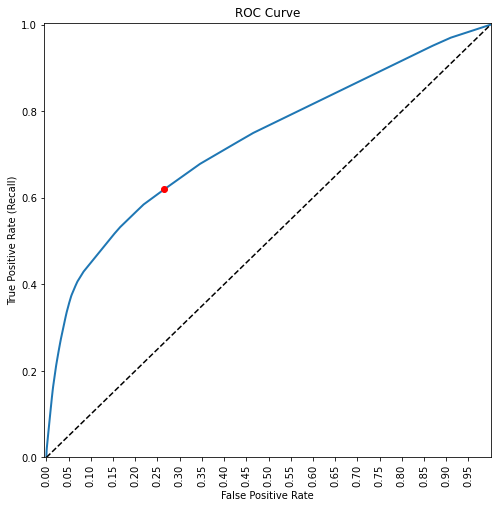

In [32]:
plot_roc_curve(fpr, tpr)
plt.plot(fpr[39], tpr[39], 'o', c='r')

# Q2e {-}
Among the months, which month is the most important in determining if a client will respond positively to the campaign, based on the model developed on *Q2b*.

*(2 points for code, 1 point for answer)*

In [33]:
pd.DataFrame({'variables': X_train.columns, 'importance': model.feature_importances_}).sort_values(by='importance', ascending=False).head()

,variables,importance
0,age,0.227924
1,day,0.190209
13,month_mar,0.098109
16,month_oct,0.098100
17,month_sep,0.091966


March is the most important month in determining if a client will respond positively.